In [26]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

df = pd.read_csv("appl-data.csv", index_col=0)
aapl = df.copy()
aapl.dropna(inplace=True)
aapl[aapl.columns] = aapl[aapl.columns].astype(float)

aapl.index.name = 'date'
aapl.index = pd.to_datetime(aapl.index)

aapl = aapl[['Close', 'High', 'Low', 'Open']]

aapl['log_return'] = np.log(aapl['Close'] / aapl['Close'].shift(1))

aapl['SMA10'] = aapl['Close'].rolling(window=10).mean() # 10-day simple moving average of the adjusted close price
aapl['volatility'] = aapl['Close'].rolling(window=10).std() # 10-day rolling standard deviation (volatility)
aapl['HL_diff'] = aapl['High'] - aapl['Low'] # difference between high and low prices (daily range)
aapl['lag1'] = aapl['log_return'].shift(1) # previous day's log return (lag-1)

# Drop initial rows with NaN values due to shifting/rolling operations
aapl.dropna(inplace=True)

# 80/20 split
split_idx = int(len(aapl) * 0.8)
train = aapl.iloc[:split_idx]
test = aapl.iloc[split_idx:]

# Optionally, select a subset of features for modeling
features = ['SMA10', 'volatility', 'HL_diff', 'lag1']
target = 'log_return'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (795, 4)
Test set shape: (199, 4)


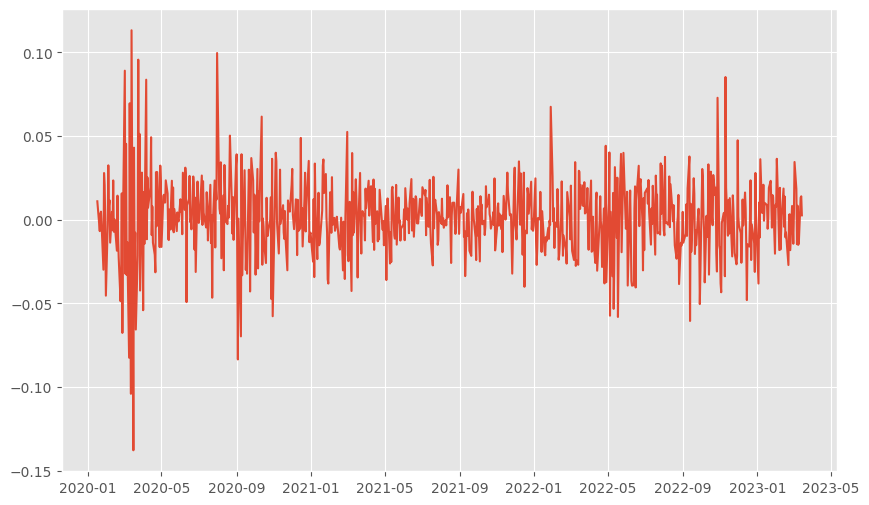

In [27]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(y_train.index, y_train)
plt.show()

In [28]:
# Standardization (fit only on training data, then apply to both train & test)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

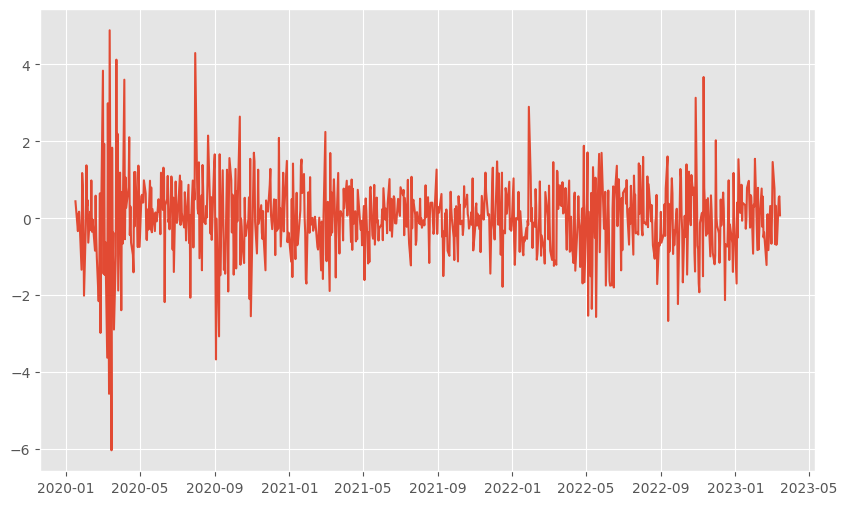

In [29]:
plt.plot(aapl.index[:y_train.shape[0]], y_train)
plt.show()

In [30]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1, prior_var = 1):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ReLU(),
        noise_std=1.0,
        prior_var = 1,
        init_var = 1
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = 2 * torch.log(torch.tensor(noise_std))

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], init_var=init_var, prior_var=prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, init_var=init_var, prior_var=prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], init_var=init_var, prior_var=prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

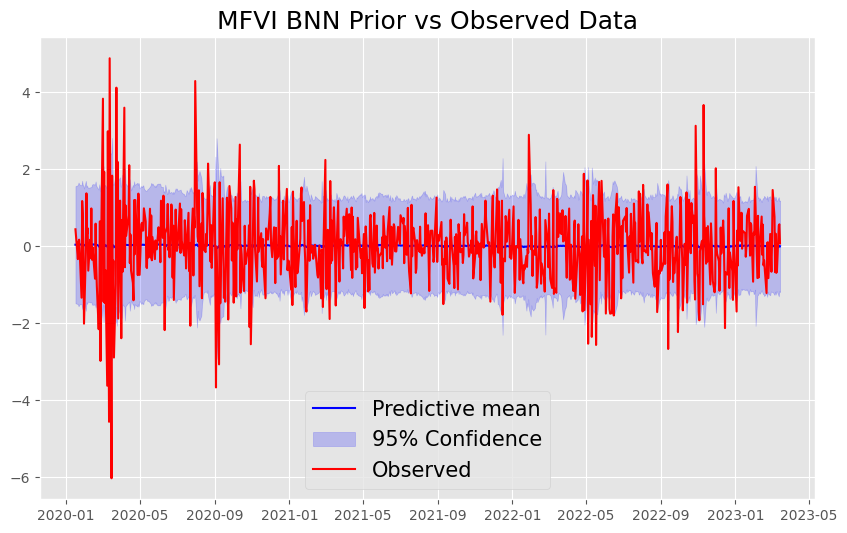

In [31]:
bnn_model = MeanFieldBNN(4, [5, 5], 1, noise_std=0.1, init_var=0.2, prior_var=0.1)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-3
)

preds = bnn_model(X_train, num_samples=500).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(aapl.index[:len(pred_mean)], pred_mean, color='blue', label='Predictive mean')
plt.fill_between(aapl.index[:len(pred_mean)], pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

plt.title("MFVI BNN Prior vs Observed Data", fontsize=18)
plt.plot(aapl.index[:len(pred_mean)], y_train, color='red', label='Observed', zorder=900)
plt.legend(fontsize=15, loc='lower center')
plt.show()

In [32]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(2000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(X_train, y_train, num_samples=100)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(X_train), y_train.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(X_test, y_test)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(X_test), y_test.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

  4%|▍         | 81/2000 [00:05<02:21, 13.54it/s]


KeyboardInterrupt: 

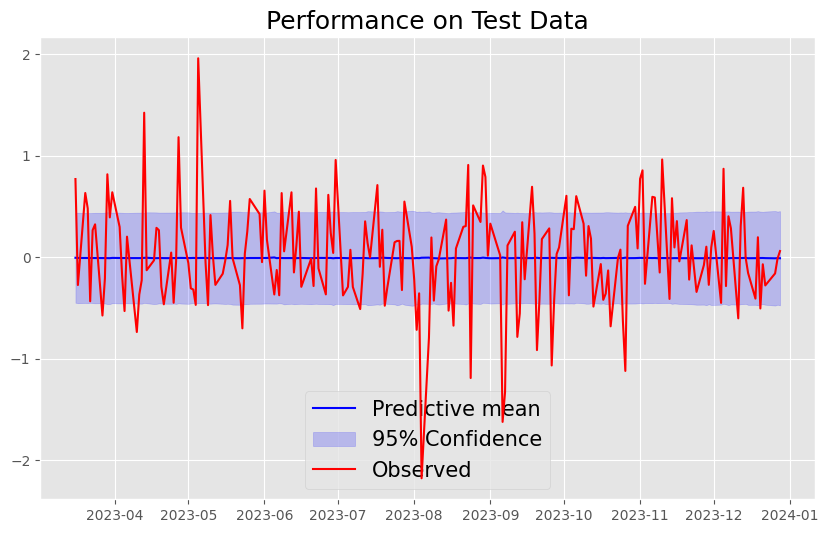

In [ ]:
preds = bnn_model(X_test, num_samples=500).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(aapl.index[-1*len(pred_mean):], pred_mean, color='blue', label='Predictive mean')
plt.fill_between(aapl.index[-1*len(pred_mean):], pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

plt.title("Performance on Test Data", fontsize=18)
plt.plot(aapl.index[-1*len(pred_mean):], y_test, color='red', label='Observed', zorder=900)
plt.legend(fontsize=15, loc='lower center')
plt.show()

Epoch 0/1000 - Loss: 1.091773
Epoch 100/1000 - Loss: 0.855445
Epoch 200/1000 - Loss: 0.676056
Epoch 300/1000 - Loss: 0.627311
Epoch 400/1000 - Loss: 0.598736
Epoch 500/1000 - Loss: 0.582584
Epoch 600/1000 - Loss: 0.578112
Epoch 700/1000 - Loss: 0.575065
Epoch 800/1000 - Loss: 0.573323
Epoch 900/1000 - Loss: 0.572187


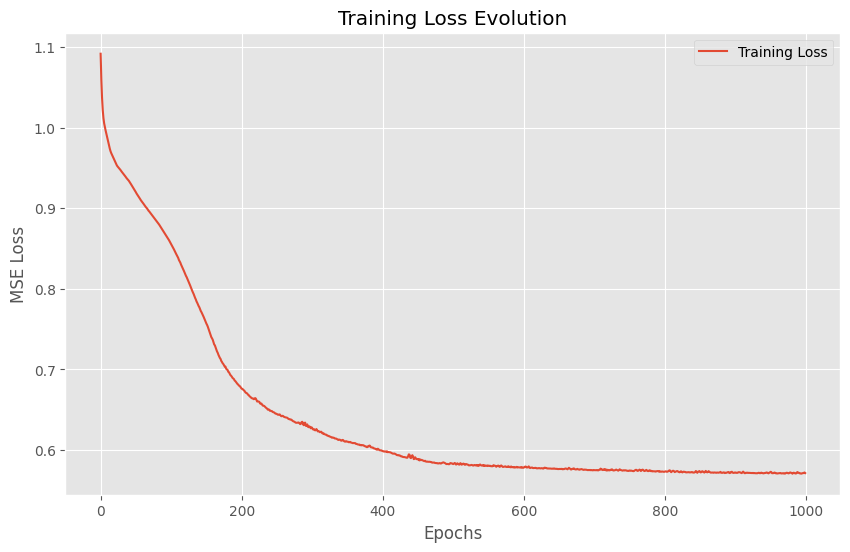

<Figure size 1000x500 with 0 Axes>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv("appl-data.csv", index_col=0)
aapl = df.copy()
aapl.dropna(inplace=True)
aapl[aapl.columns] = aapl[aapl.columns].astype(float)

aapl.index.name = 'date'
aapl.index = pd.to_datetime(aapl.index)

# Select features
aapl = aapl[['Close', 'High', 'Low', 'Open']]
aapl['log_return'] = np.log(aapl['Close'] / aapl['Close'].shift(1))
aapl['SMA10'] = aapl['Close'].rolling(window=10).mean()
aapl['volatility'] = aapl['Close'].rolling(window=10).std()
aapl['HL_diff'] = aapl['High'] - aapl['Low']
aapl['lag1'] = aapl['log_return'].shift(1)

# Drop NaNs
aapl.dropna(inplace=True)

# Split into train/test
split_idx = int(len(aapl) * 0.8)
train = aapl.iloc[:split_idx]
test = aapl.iloc[split_idx:]

features = ['SMA10', 'volatility', 'HL_diff', 'lag1']
target = 'log_return'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Standardize data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# Define MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model
mlp_model = SimpleMLP(input_dim=X_train.shape[1])

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2)

# Training loop
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = mlp_model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.6f}")

# Plot training loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Evolution")
plt.legend()
plt.show()

# Evaluate model
with torch.no_grad():
    y_pred_test = mlp_model(X_test).squeeze().numpy()

# Convert predictions back to original scale
y_pred_test_original = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Plot results
plt.figure(figsize=(10,5))
plt.show()


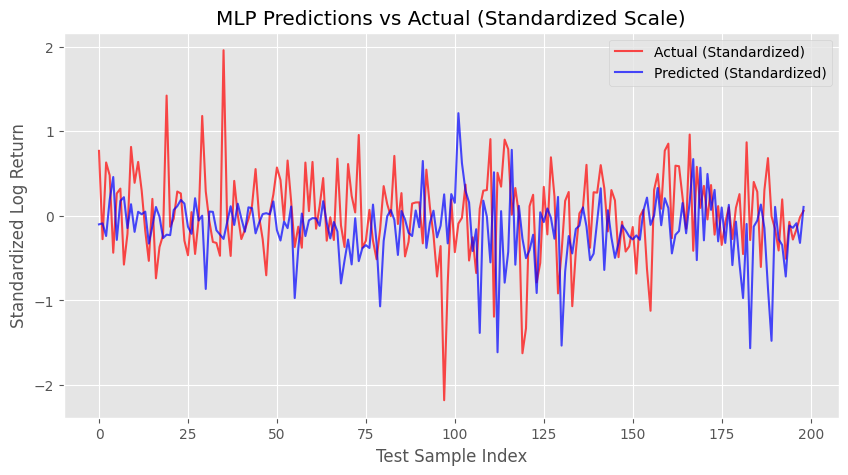

In [ ]:
# Evaluate model on test set
with torch.no_grad():
    y_pred_test = mlp_model(X_test).squeeze().numpy()

# Convert tensors to NumPy arrays for plotting
y_test_np = y_test.numpy()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_np, label="Actual (Standardized)", color='red', alpha=0.7)
plt.plot(y_pred_test, label="Predicted (Standardized)", color='blue', alpha=0.7)
plt.xlabel("Test Sample Index")
plt.ylabel("Standardized Log Return")
plt.title("MLP Predictions vs Actual (Standardized Scale)")
plt.legend()
plt.show()


100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


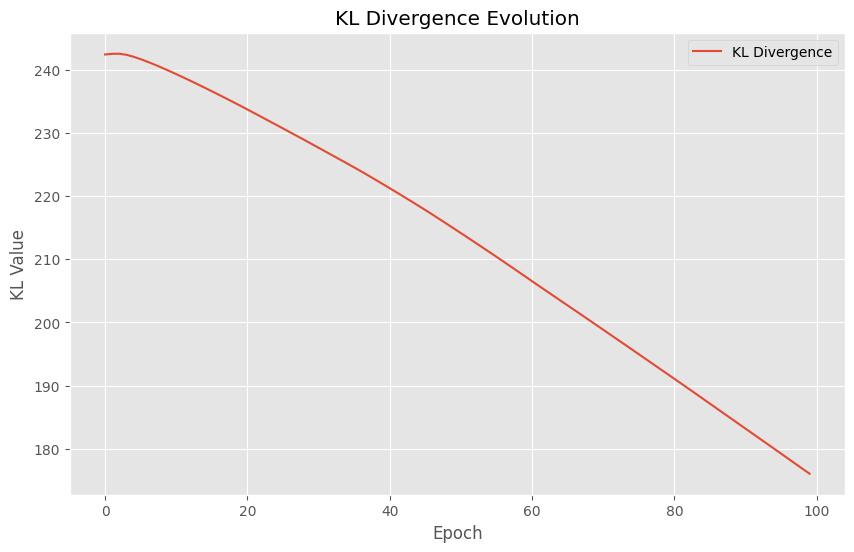

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from tqdm import tqdm

class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_std=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Variational Parameters (Mean & Log Variance)
        self.w_mu = nn.Parameter(torch.zeros(in_features, out_features))
        self.w_log_var = nn.Parameter(torch.full((in_features, out_features), -5.0))  # Small initial variance
        self.b_mu = nn.Parameter(torch.zeros(out_features))
        self.b_log_var = nn.Parameter(torch.full((out_features,), -5.0))

        # Prior Distribution
        self.prior_w = Normal(0, prior_std)
        self.prior_b = Normal(0, prior_std)

    def forward(self, x):
        # Reparameterization Trick: Sample Weights
        w_std = torch.exp(0.5 * self.w_log_var)  # Convert log variance to std
        b_std = torch.exp(0.5 * self.b_log_var)

        w_sample = self.w_mu + w_std * torch.randn_like(w_std)
        b_sample = self.b_mu + b_std * torch.randn_like(b_std)

        return x @ w_sample + b_sample

    def kl_divergence(self):
        """ Compute KL divergence between learned distribution and prior. """
        w_posterior = Normal(self.w_mu, torch.exp(0.5 * self.w_log_var))
        b_posterior = Normal(self.b_mu, torch.exp(0.5 * self.b_log_var))

        kl_w = torch.distributions.kl.kl_divergence(w_posterior, self.prior_w).sum()
        kl_b = torch.distributions.kl.kl_divergence(b_posterior, self.prior_b).sum()

        return kl_w + kl_b

class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, prior_std=1.0):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, hidden_dim, prior_std)
        self.blinear2 = BayesianLinear(hidden_dim, output_dim, prior_std)

    def forward(self, x):
        x = F.relu(self.blinear1(x))
        return self.blinear2(x)

    def kl_divergence(self):
        return self.blinear1.kl_divergence() + self.blinear2.kl_divergence()

# ================== Training Bayesian Neural Network ==================
def train_bnn(model, X_train, y_train, X_test, y_test, epochs=500, lr=0.01, num_samples=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    kl_values = []

    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()

        # Sample multiple times for Monte Carlo estimate
        predictions = torch.stack([model(X_train) for _ in range(num_samples)])
        log_likelihood = -F.mse_loss(predictions.mean(dim=0), y_train, reduction="sum")

        kl = model.kl_divergence()
        beta = min(1.0, epoch / 100)  # KL Annealing
        loss = -log_likelihood + beta * kl

        loss.backward()
        optimizer.step()

        # Track losses
        train_losses.append(loss.item())
        kl_values.append(kl.item())

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_preds = torch.stack([model(X_test) for _ in range(num_samples)])
            test_loss = F.mse_loss(test_preds.mean(dim=0), y_test, reduction="sum").item()
            test_losses.append(test_loss)

    return train_losses, test_losses, kl_values

# ================== Convert Data to PyTorch ==================
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# ================== Train the BNN ==================
bnn = BayesianNN(input_dim=X_train.shape[1], hidden_dim=20, output_dim=1, prior_std=1.0)
train_losses, test_losses, kl_values = train_bnn(bnn, X_train, y_train, X_test, y_test, epochs=100, num_samples=500)

# ================== Plot KL Divergence Evolution ==================
import matplotlib.pyplot as plt

plt.plot(kl_values, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("KL Value")
plt.title("KL Divergence Evolution")
plt.legend()
plt.show()


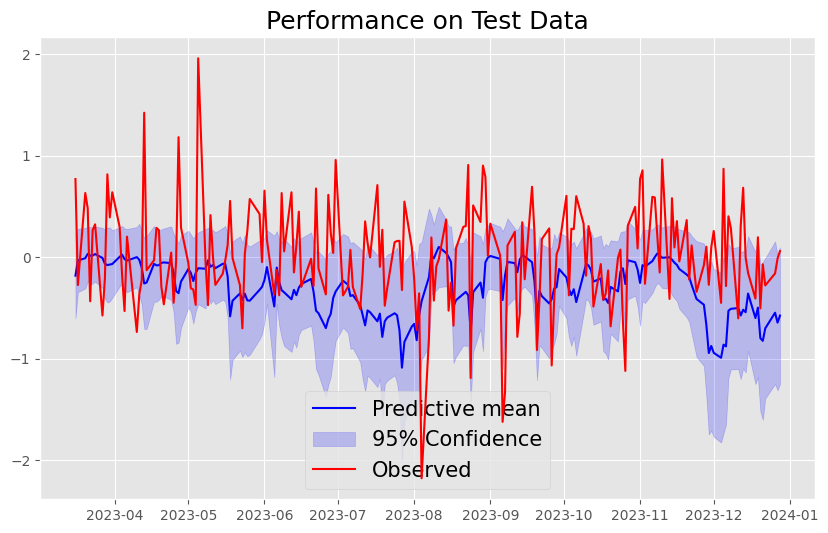

In [ ]:
import torch

def predict_bnn(model, X_test, n_samples=100):
    model.eval()  # Set the model to evaluation mode
    
    predictions = []
    
    # Sample predictions n_samples times
    for _ in range(n_samples):
        # Get predictions by sampling from the posterior for each forward pass
        pred = model(X_test)  # This will internally sample weights from the posterior
        predictions.append(pred.unsqueeze(0).detach())  # Detach and add a new dimension for stacking
    
    # Stack the predictions into a single tensor
    predictions = torch.cat(predictions, dim=0)
    return predictions.squeeze(-1)

preds = predict_bnn(bnn, X_test, n_samples=500)
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(aapl.index[-1*len(pred_mean):], pred_mean, color='blue', label='Predictive mean')
plt.fill_between(aapl.index[-1*len(pred_mean):], pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

plt.title("Performance on Test Data", fontsize=18)
plt.plot(aapl.index[-1*len(pred_mean):], y_test, color='red', label='Observed', zorder=900)
plt.legend(fontsize=15, loc='lower center')
plt.show()
